
# Semana 6 — Perceptron (Introdução + Mão na Massa) ⚡️

Neste notebook você vai:
1) Entender rapidamente o **Perceptron** (classificador linear).  
2) Treinar um modelo com `scikit-learn` em dados 2D.  
3) Avaliar (acurácia + matriz de confusão).  
4) Visualizar a **fronteira de decisão**.  

> Dicas:
> - O Perceptron encontra um **hiperplano** que separa as classes (se forem linearmente separáveis).
> - Hiperparâmetros: `alpha`, `max_iter`, `eta0` (via `SGDClassifier`).


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## 1) Gerar dados sintéticos (2D)

In [3]:

X, y = make_classification(
    n_samples=600, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, class_sep=1.5, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)
print("Shapes:", X_train_std.shape, X_test_std.shape)


Shapes: (450, 2) (150, 2)


## 2) Treinar o Perceptron

In [4]:

clf = Perceptron(max_iter=1000, tol=1e-3, alpha=0.0001, fit_intercept=True, random_state=42)
clf.fit(X_train_std, y_train)
print("Coef_:", clf.coef_)
print("Intercept:", clf.intercept_)


Coef_: [[ 5.75834364 -0.84943027]]
Intercept: [-1.]


## 3) Avaliação do modelo

In [5]:

y_pred = clf.predict(X_test_std)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Acurácia: {acc:.3f}")
print("Matriz de confusão:\n", cm)
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred))


Acurácia: 0.987
Matriz de confusão:
 [[73  2]
 [ 0 75]]

Relatório de classificação:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        75
           1       0.97      1.00      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



## 4) Fronteira de decisão (2D)

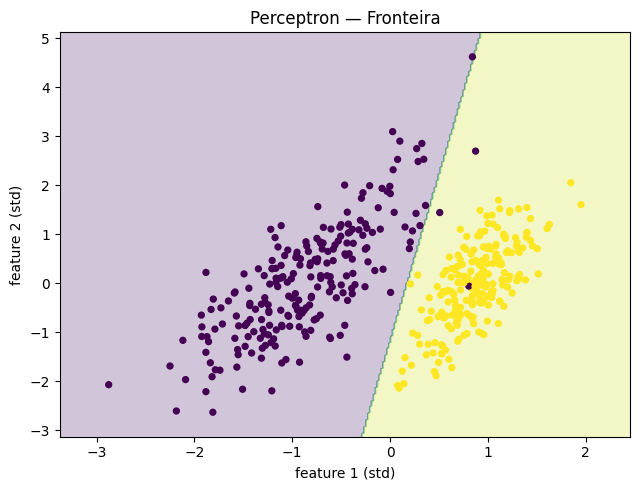

In [6]:

def plot_decision_boundary(model, X, y, title="Perceptron — Fronteira"):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(6.5,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, s=18)
    plt.title(title); plt.xlabel("feature 1 (std)"); plt.ylabel("feature 2 (std)")
    plt.tight_layout(); plt.show()

plot_decision_boundary(clf, X_train_std, y_train)


## 5) Sem padronizar (comparação rápida)

In [7]:

clf_raw = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
clf_raw.fit(X_train, y_train)
acc_raw = accuracy_score(y_test, clf_raw.predict(X_test))
print(f"Acurácia sem padronizar: {acc_raw:.3f}")


Acurácia sem padronizar: 0.967


## 6) Taxa de aprendizado (`eta0`) via SGDClassifier

In [8]:

etas = [0.001, 0.01, 0.1]
rows = []
for eta in etas:
    sgd = SGDClassifier(loss="perceptron", learning_rate="constant", eta0=eta,
                        max_iter=1000, tol=1e-3, random_state=42)
    sgd.fit(X_train_std, y_train)
    acc_sgd = accuracy_score(y_test, sgd.predict(X_test_std))
    rows.append((eta, acc_sgd))
pd.DataFrame(rows, columns=["eta0","acuracia_teste"])


,eta0,acuracia_teste
0,0.001,0.980000
1,0.010,0.980000
2,0.100,0.986667


## 7) Limitação com dados não lineares (meia-lua)

Acurácia (moons): 0.840


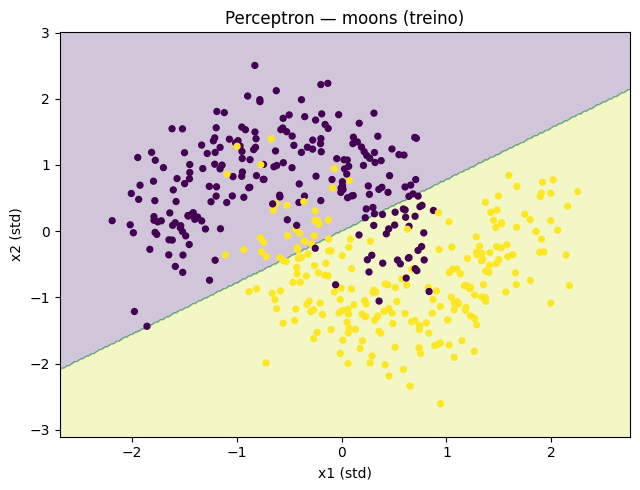

In [9]:

Xm, ym = make_moons(n_samples=600, noise=0.25, random_state=42)
Xm_tr, Xm_te, ym_tr, ym_te = train_test_split(Xm, ym, test_size=0.25, random_state=42, stratify=ym)
sc_m = StandardScaler()
Xm_tr_s = sc_m.fit_transform(Xm_tr); Xm_te_s = sc_m.transform(Xm_te)

clf_m = Perceptron(max_iter=1000, tol=1e-3, random_state=42).fit(Xm_tr_s, ym_tr)
acc_m = accuracy_score(ym_te, clf_m.predict(Xm_te_s))
print(f"Acurácia (moons): {acc_m:.3f}")

# plot
def plot_db(model, X, y, title=""):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(6.5,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, s=18)
    plt.title(title); plt.xlabel("x1 (std)"); plt.ylabel("x2 (std)")
    plt.tight_layout(); plt.show()

plot_db(clf_m, Xm_tr_s, ym_tr, "Perceptron — moons (treino)")
